In [26]:
!pip install pingouin

import pandas as pd
import matplotlib.colors as mcolors
import colorsys
import itertools
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from heatindex import heatindex
from tqdm import tqdm
import pingouin as pg
# !pip install geopy
import itertools
tqdm.pandas()
from mpl_toolkits.axes_grid1 import make_axes_locatable

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 1.3 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.7 MB/s eta 0:00:00a 0:00:01


In [27]:
outdoor_temp = pd.read_csv('./campaign_data/outdoor_temp.csv')

figure_directory = 'paper_plots'

# Convert 'Date/Time' to datetime format
outdoor_temp['Date/Time'] = pd.to_datetime(outdoor_temp['Date/Time'])

# Set 'Date/Time' as the index
outdoor_temp.set_index('Date/Time', inplace=True)

outdoor_temp['Hour'] = outdoor_temp.index.hour

# Humidity data
outdoor_hum = pd.read_csv('./campaign_data/outdoor_hum.csv')

# Convert 'Date/Time' to datetime format
outdoor_hum['Date/Time'] = pd.to_datetime(outdoor_hum['Date/Time'])

# Set 'Date/Time' as the index
outdoor_hum.set_index('Date/Time', inplace=True)

outdoor_hum['Hour'] = outdoor_hum.index.hour

# Now you can safely round the index and extract the hour
outdoor_temp['Original_Outdoor_Time'] = outdoor_temp.index.round('H').hour

/tmp/ipykernel_1049/3849593911.py:1: DtypeWarning: Columns (7,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  outdoor_temp = pd.read_csv('./campaign_data/outdoor_temp.csv')
/tmp/ipykernel_1049/3849593911.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  outdoor_hum = pd.read_csv('./campaign_data/outdoor_hum.csv')


In [28]:
site_type = {'AD': ['Asylum Down', 'Commercial/\nbusiness/\nindustrial','blue'],
             'ASH' : ['Ashaiman', 'Medium/low-density\nresidential', 'tab:orange'],
             'EL': ['East Legon', 'Medium/low-density\nresidential', 'tab:orange'],
             'JT' : ['James Town', 'High-density\nresidential', 'red'],
             'LA': ['Labadi', 'Medium/low-density\nresidential', 'tab:orange'],
             'N1W': ['N1 West Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'NM': ['Nima', 'High-density\nresidential', 'red'],
             'TF': ['Taifa','Medium/low-density\nresidential', 'tab:orange'],
             'TMW': ['Tema Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'UGH': ['University of Ghana', 'Peri-urban background', 'green']}

land_use_type = {'low-dens' : 'Medium/low-density residential', 'high-dens': 'High-density residential', 'commercial': 'Commercial/business/industrial', 'other': 'Peri-urban background' }

In [29]:
# Group by 'sensor_id' and calculate the number of unique 'site_id's for each 'sensor_id'
unique_site_ids_per_sensor = outdoor_temp.groupby('sensor_id_outdoor_temp')['site_id'].nunique()

# Check if any 'sensor_id' is associated with more than one 'site_id'
multiple_sites_per_sensor = unique_site_ids_per_sensor[unique_site_ids_per_sensor > 1]

if len(multiple_sites_per_sensor) > 0:
    print("These sensor_ids are associated with multiple site_ids:")
    print(multiple_sites_per_sensor)
else:
    print("Every sensor_id is associated with a unique site_id.")


Every sensor_id is associated with a unique site_id.


In [30]:
outdoor_temp['Hour']

Date/Time
2022-08-05 09:00:00    9
2022-08-05 09:10:00    9
2022-08-05 09:20:00    9
2022-08-05 09:30:00    9
2022-08-05 09:40:00    9
                      ..
2023-09-25 06:31:00    6
2023-09-25 06:41:00    6
2023-09-25 06:51:00    6
2023-09-25 07:01:00    7
2023-09-25 07:11:00    7
Name: Hour, Length: 1334682, dtype: int32

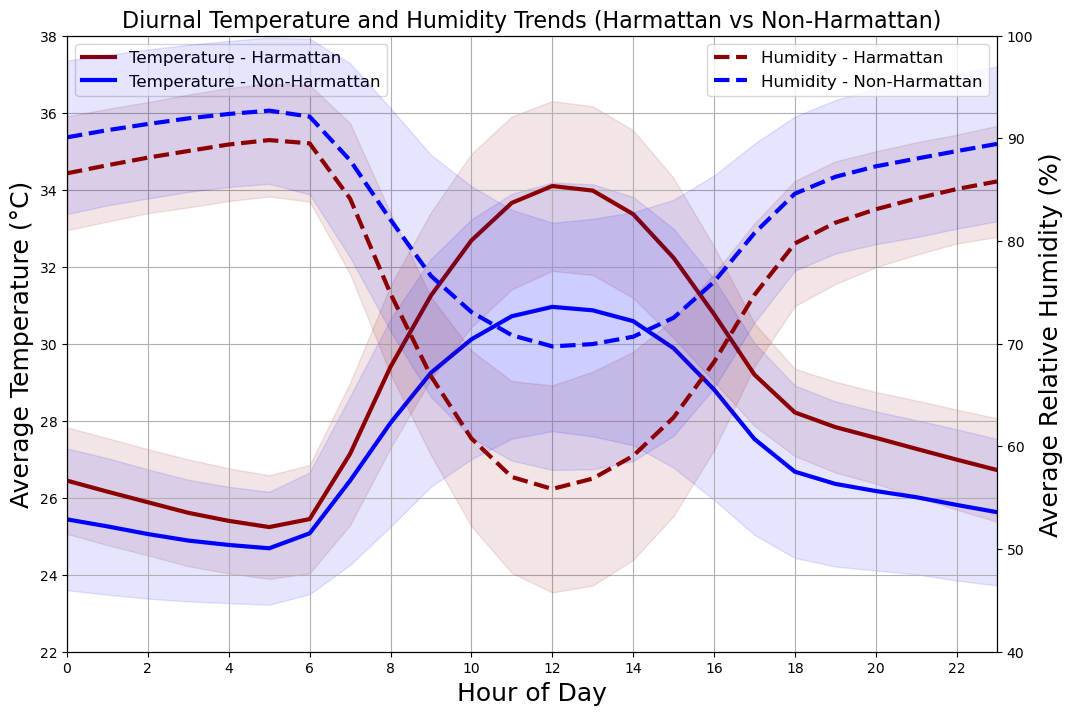

In [31]:
import matplotlib.pyplot as plt


# Define the season and add it as a new column
outdoor_temp['Season'] = outdoor_temp.index.month.map({11: 'Harmattan', 12: 'Harmattan', 1: 'Harmattan', 2: 'Harmattan',3: 'Harmattan'}).fillna('Non-Harmattan')

# Define the season and add it as a new column
outdoor_hum['Season'] = outdoor_hum.index.month.map({11: 'Harmattan', 12: 'Harmattan', 1: 'Harmattan', 2: 'Harmattan',3: 'Harmattan',}).fillna('Non-Harmattan')


# Define the color maps for temperature and humidity
temp_color_map = {'Harmattan': 'darkred', 'Non-Harmattan': 'blue'}
# hum_color_map = {'Harmattan': 'lightcoral', 'Non-Harmattan': 'lightblue'}
hum_color_map = temp_color_map

# Group the temperature data
temp_grouped = outdoor_temp.groupby(['Season', 'Hour'])['Value'].agg(['mean', 'std']).reset_index()

# Group the humidity data
hum_grouped = outdoor_hum.groupby(['Season', 'Hour'])['Value'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12, 8))

# Create the primary axis for temperature
ax_temp = plt.gca()

for season in temp_grouped['Season'].unique():
    season_data = temp_grouped[temp_grouped['Season'] == season]
    ax_temp.plot(season_data['Hour'], season_data['mean'], label=f'Temperature - {season}', color=temp_color_map[season], lw=3)
    ax_temp.fill_between(season_data['Hour'], season_data['mean'] - season_data['std'], season_data['mean'] + season_data['std'], color=temp_color_map[season], alpha=0.1)

# Create the secondary axis for humidity
ax_hum = ax_temp.twinx()

for season in hum_grouped['Season'].unique():
    season_data = hum_grouped[hum_grouped['Season'] == season]
    ax_hum.plot(season_data['Hour'], season_data['mean'], label=f'Humidity - {season}', color=hum_color_map[season], lw=3, linestyle='--')
    ax_hum.fill_between(season_data['Hour'], season_data['mean'] - season_data['std'], season_data['mean'] + season_data['std'], color=hum_color_map[season], alpha=0.1)

# Set labels and title
ax_temp.set_xlabel('Hour of Day', fontsize=18)
ax_temp.set_ylabel('Average Temperature (°C)', fontsize=18)
ax_hum.set_ylabel('Average Relative Humidity (%)', fontsize=18)
plt.title('Diurnal Temperature and Humidity Trends (Harmattan vs Non-Harmattan)', fontsize=16)

# Set limits and ticks
ax_temp.set_xlim(0, 23)
ax_temp.set_ylim(22, 38)
ax_hum.set_ylim(40, 100)
plt.xticks(range(0, 24, 2))

# Add legends
temp_legend = ax_temp.legend(loc='upper left', fontsize=12)
hum_legend = ax_hum.legend(loc='upper right', fontsize=12)

# Add grid
ax_temp.grid(True)

plt.savefig(figure_directory+'/diurnal_temp_humidity_plot_harmattan.png', facecolor='white', bbox_inches='tight')
plt.show()

In [32]:
ndvi_values = pd.read_csv('updated_sites_lat_long_ndvi.csv')
ndbi_values = pd.read_csv('updated_sites_lat_long_ndbi.csv')


In [33]:
outdoor_temp.head()

,point_id_outdoor_temp,Unit,Value,sensor_id_outdoor_temp,site_id,filename,hh_notes_out,gps_lat_out,gps_long_out,gps_ghanapost_out,...,site_type,Road_surface,pop_dens,WB_cat,ndvi,pop_dens_cat,ndvi_cat,Hour,Original_Outdoor_Time,Season
Date/Time,,,,,,,,,,,,,,,,,,,,,
2022-08-05 09:00:00,AD_3F6B_8704,C,28.0,'3F6B',AD,data_in/Outdoor_Data/Temperature_Data/AD_2022_...,NaN,5.57116,-0.211048,NaN,...,commercial,Asphalt,189.562943,3,0.050303,high,low,9,9,Non-Harmattan
2022-08-05 09:10:00,AD_3F6B_8704,C,25.5,'3F6B',AD,data_in/Outdoor_Data/Temperature_Data/AD_2022_...,NaN,5.57116,-0.211048,NaN,...,commercial,Asphalt,189.562943,3,0.050303,high,low,9,9,Non-Harmattan
2022-08-05 09:20:00,AD_3F6B_8704,C,25.5,'3F6B',AD,data_in/Outdoor_Data/Temperature_Data/AD_2022_...,NaN,5.57116,-0.211048,NaN,...,commercial,Asphalt,189.562943,3,0.050303,high,low,9,9,Non-Harmattan
2022-08-05 09:30:00,AD_3F6B_8704,C,26.0,'3F6B',AD,data_in/Outdoor_Data/Temperature_Data/AD_2022_...,NaN,5.57116,-0.211048,NaN,...,commercial,Asphalt,189.562943,3,0.050303,high,low,9,10,Non-Harmattan
2022-08-05 09:40:00,AD_3F6B_8704,C,26.0,'3F6B',AD,data_in/Outdoor_Data/Temperature_Data/AD_2022_...,NaN,5.57116,-0.211048,NaN,...,commercial,Asphalt,189.562943,3,0.050303,high,low,9,10,Non-Harmattan


In [34]:
# indoor_temp = pd.read_csv('./tagged_data_no_threshold/indoor_sen_meta_tagged.csv') 
indoor_temp = pd.read_csv('./campaign_data/indoor_temp.csv')
indoor_temp['Date/Time'] = pd.to_datetime(indoor_temp['Date/Time'])
indoor_temp.set_index('Date/Time', inplace=True)
common_sites = set(indoor_temp['site_id']).intersection(set(outdoor_temp['site_id']))

/tmp/ipykernel_1049/3531141079.py:2: DtypeWarning: Columns (7,8,11,12,13,25,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  indoor_temp = pd.read_csv('./campaign_data/indoor_temp.csv')


In [35]:
indoor_temp['point_id_indoor_temp'].unique()
# indoor_temp['hh_id'].unique()

array(['AD_6702', 'AD_745A', 'ASH_1A3E', 'EL_4158', 'EL_7128', 'EL_7175',
       'JT_67C0', 'JT_8872_6F24', 'JT_ECF7', 'JT_EEFC', 'LA_4036',
       'LA_4B8F', 'N1W_044F', 'N1W_54DA', 'N1W_FC9A', 'NM_12F4',
       'NM_4A7D', 'NM_5024', 'NM_F447', 'S0_4C16', 'S0_5A4F', 'S0_FA88',
       'S101_5032', 'S101_5B25', 'S101_6EB0', 'S104_3DC6', 'S104_9ABE',
       'S105_0557', 'S105_2250', 'S109_1713', 'S109_4665', 'S109_74C7',
       'S110_06E2', 'S110_F440', 'S110_F4ED', 'S111_3FF7', 'S112_5A29',
       'S112_9F81', 'S113_3D23', 'S114_1E69', 'S114_1EFE', 'S114_22F5',
       'S114_4E9E', 'S115_4116', 'S115_4D2C', 'S115_5B6F', 'S11_049E',
       'S124_05A8', 'S124_571C', 'S124_7231', 'S129_2073', 'S129_8117',
       'S12_1EFE', 'S12_5F73', 'S135_6066', 'S136_0ED6', 'S136_7300',
       'S139_7165', 'S147_0271', 'S14_9355', 'S14_9917', 'S154_621D',
       'S154_72A0', 'S168_6694', 'S168_9BD1', 'S169_46B5', 'S1_3F89',
       'S1_4719', 'S1_747C', 'S21_5BC9', 'S22_1048', 'S22_6448',
       'S22_84F

In [36]:
# Rename 'Value' column in indoor dataframe to avoid confusion after merge
indoor_temp.rename(columns={'Value': 'Indoor_Value'}, inplace=True)

indoor_temp['Original_Indoor_Time'] = indoor_temp.index.round('H').hour
# outdoor_temp['Original_Outdoor_Time'] = outdoor_temp.index.round('H').hour

# Sort both dataframes by 'Date/Time' and 'site_id'
outdoor_temp.sort_values(['Date/Time', 'site_id'], inplace=True)
indoor_temp.sort_values(['Date/Time', 'site_id'], 
                        inplace=True)

# Merge the dataframes
merged_df = pd.merge_asof(indoor_temp, outdoor_temp, 
                          on='Date/Time', by='site_id', 
                          tolerance=pd.Timedelta('1 hour'), direction='nearest', suffixes = ('_outdoor', '_indoor'))

merged_df['Temp_diff'] = merged_df['Indoor_Value'] - merged_df['Value']
merged_df['Date/Time'] = pd.to_datetime(merged_df['Date/Time'])
merged_df['Day/night'] = merged_df['Date/Time'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')


In [37]:
# Assuming merged_df and ndvi_values are already loaded as described
# Convert 'site_id' to string if not already (in both dataframes)
merged_df['site_id'] = merged_df['site_id'].astype(str)
ndvi_values['site_id'] = ndvi_values['site_id'].astype(str)
ndbi_values['site_id'] = ndbi_values['site_id'].astype(str)

# Merge NDVI values with merged_df
merged_df = pd.merge(merged_df, ndvi_values[['site_id', 'mean_ndvi']], on='site_id', how='left')
# Merge NDVI values with merged_df
merged_df = pd.merge(merged_df, ndbi_values[['site_id', 'mean_ndbi']], on='site_id', how='left')

# Now merged_df contains the NDVI values along with other data


In [60]:
# Assuming your dataframe has a datetime column named "timestamp"
merged_df['Date'] = merged_df['Date/Time'].dt.date

# Step 1: Day-Level Aggregation with 'site_type_outdoor'
day_level = merged_df.groupby(['sensor_id_indoor_temp', 'Date', 'Day/night']).agg(
    daily_mean_indoor=('Indoor_Value', 'mean'),
    daily_mean_outdoor=('Value', 'mean'),
    daily_max_indoor=('Indoor_Value', 'max'),
    daily_max_outdoor=('Value', 'max'),
    site_type_outdoor=('site_type_outdoor', 'first'),  # Assuming each sensor_id, Date, Day/night combo has a single site type
    mean_ndvi=('mean_ndvi', 'first'),  # Assuming each sensor_id, Date, Day/night combo has a single site type
    mean_ndbi=('mean_ndbi', 'first')  # Assuming each sensor_id, Date, Day/night combo has a single site type
).reset_index()

# Step 2: Sensor-Level Aggregation
aggregated_data = day_level.groupby(['sensor_id_indoor_temp', 'Day/night']).agg(
    average_daily_mean_indoor=('daily_mean_indoor', 'mean'),
    average_daily_mean_outdoor=('daily_mean_outdoor', 'mean'),
    average_daily_max_indoor=('daily_max_indoor', 'mean'),
    average_daily_max_outdoor=('daily_max_outdoor', 'mean'),
    mean_ndvi=('mean_ndvi', 'first'),
    mean_ndbi=('mean_ndbi', 'first')
).reset_index()

In [39]:
len(merged_df['point_id_indoor_temp'].unique())
# indoor_temp['hh_id'].unique()

132

/tmp/ipykernel_1049/3629877474.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


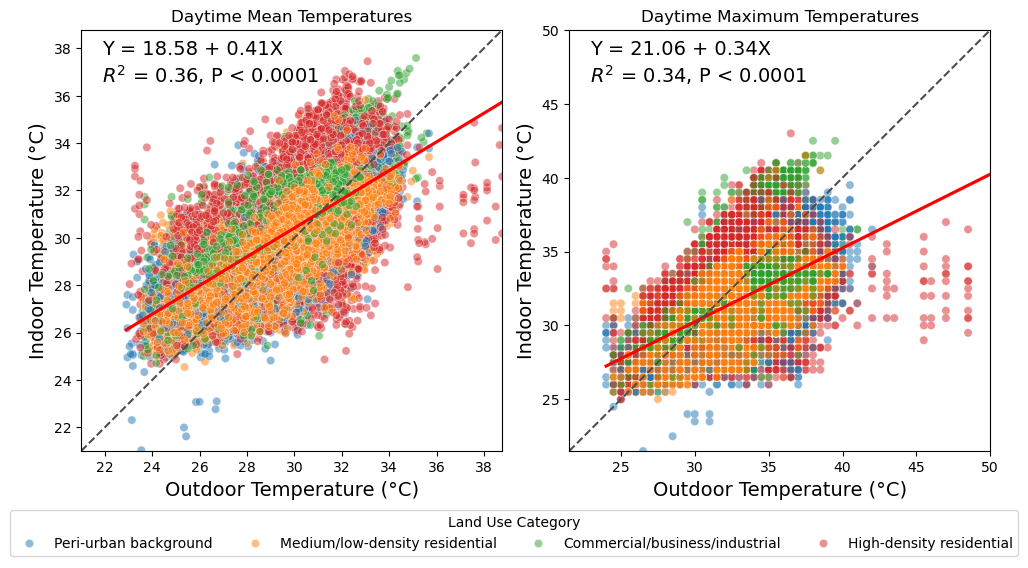

In [40]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Function to annotate fit
def annotate_fit(x, y, ax):
    # Drop NaN values
    df = pd.DataFrame({'x': x, 'y': y}).dropna()
    X = sm.add_constant(df['x'])
    model = sm.OLS(df['y'], X).fit()
    a, b = model.params['const'], model.params['x']
    r2 = model.rsquared
    p_value_slope = model.pvalues['x']
    if p_value_slope < 0.0001:
        p_text = "P < 0.0001"
    else:
        p_text = f"P = {p_value_slope:.4f}"
    ax.annotate(f'Y = {a:.2f} + {b:.2f}X\n$R^2$ = {r2:.2f}, {p_text}', xy=(0.05, 0.875), xycoords='axes fraction', fontsize=14)

# Choose either 'day_level' or 'aggregated_data' for analysis
analysis_level = 'day_level'  # Set to either 'day' or 'aggregated'

if analysis_level == 'day_level':
    analysis_frame = day_level
    axis_prefix = 'Daily'
elif analysis_level == 'aggregated':
    analysis_frame = aggregated_data
    axis_prefix = 'Average Daily'

# Convert site types to labels
analysis_frame['site_type_outdoor'] = analysis_frame['site_type_outdoor'].map(land_use_type)

day_night = 'Day'  # Change as needed

plt.figure(figsize=(10, 10))  # Adjusted for a square plot

# Helper function to find the common limits
def find_common_limits(series1, series2, upper_bound=None):
    combined = pd.concat([series1, series2], ignore_index=True)
    lower = combined.min()
    upper = combined.max()
    if upper_bound is not None:
        upper = min(upper, upper_bound)
    return lower, upper
    
# Find the common limits for mean temperatures
mean_limits = find_common_limits(analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_outdoor'], 
                                 analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_indoor'])

# Mean average temperatures
ax1 = plt.subplot(121)
# Use sns.scatterplot() instead of sns.regplot() for hue
sns.scatterplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_mean_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_mean_indoor',
                hue='site_type_outdoor',
                # palette='viridis',
                alpha=0.5,
                legend="full",
                ax=ax1)
sns.regplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
            x=axis_prefix.lower().replace(' ','_')+'_mean_outdoor', 
            y=axis_prefix.lower().replace(' ','_')+'_mean_indoor', 
            ax=ax1, 
            scatter = False,
            # scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'}, 
            ci=95)
ax1.set_xlim(mean_limits)
ax1.set_ylim(mean_limits)
ax1.set_aspect('equal')
ax1.plot(mean_limits, mean_limits, ls="--", c=".3")  # x=y line
ax1.set_title(f'{day_night}time Mean Temperatures')
ax1.set_ylabel('Indoor Temperature (°C)', fontsize = 14)
ax1.set_xlabel('Outdoor Temperature (°C)', fontsize = 14)
annotate_fit(analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_outdoor'], analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_indoor'], ax1)

if day_night == 'Day':
    max_limits = find_common_limits(analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_outdoor'], 
                                    analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_indoor'],
                                    upper_bound=50)  # Set upper bound to 50

    # Mean maximum temperatures
    ax2 = plt.subplot(122)
    sns.scatterplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_max_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_max_indoor',
                hue='site_type_outdoor',
                # palette='viridis',
                alpha = 0.5,
                legend=False,
                ax=ax2)
    sns.regplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_max_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_max_indoor', 
                ax=ax2, 
                # scatter_kws={'alpha': 0.5}, 
                scatter = False,
                line_kws={'color': 'red'}, 
                ci=95)
    ax2.set_xlim(max_limits)
    ax2.set_ylim(max_limits)
    ax2.set_aspect('equal')
    ax2.plot(max_limits, max_limits, ls="--", c=".3")  # x=y line
    ax2.set_title(f'{day_night}time Maximum Temperatures')
    ax2.set_ylabel('Indoor Temperature (°C)', fontsize = 14)
    ax2.set_xlabel('Outdoor Temperature (°C)', fontsize = 14)
    annotate_fit(analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_outdoor'], analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_indoor'], ax2)

# After all plotting commands:
# Obtain the handles and labels from one of the scatterplots (either ax1 or ax2)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend_.remove()
# # Create a custom legend for the entire figure using ax.legend()
# ax1.legend(handles=handles, labels=labels, title='Land Use Category', 
#            loc='upper center', bbox_to_anchor=(0.5, -0.15), 
#            ncol=len(labels), fontsize='small')
# Create a new axis for the legend at the bottom
legend_ax = plt.gcf().add_axes([0.15, 0.05, 0.7, 0.05], frame_on=False)  # Adjust the values if necessary
legend_ax.axis('off')

# Create a custom legend for the entire figure using legend_ax.legend()
legend_ax.legend(handles=handles, labels=labels, title='Land Use Category',
                 loc='center', ncol=len(labels), fontsize='medium')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=-0.25)  # Provide space at the bottom for the legend

plt.savefig(f"{figure_directory}/{analysis_level}_{day_night}_correlation_indoor_outdoor.png", bbox_inches='tight')


In [41]:
import statsmodels.api as sm

x = aggregated_data['mean_ndvi']
y = aggregated_data['average_daily_mean_outdoor']

print(x.corr(y))


-0.11302252033598889


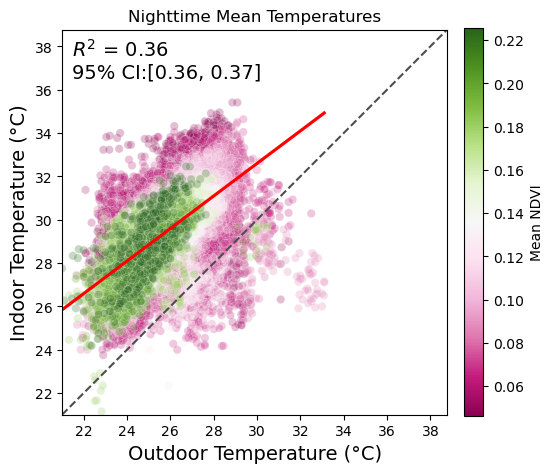

In [61]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def annotate_fit(x, y, ax):
    # Drop NaN values
    df = pd.DataFrame({'x': x, 'y': y}).dropna()
    X = sm.add_constant(df['x'])
    model = sm.OLS(df['y'], X).fit()
    a, b = model.params['const'], model.params['x']
    r2 = model.rsquared
    
    # Calculate the confidence interval for R using Pingouin
    ci = pg.corr(x=df['x'], y=df['y']).loc['pearson', 'CI95%']
    # Square the CI values to get the CI for R^2
    ci_r2 = [value**2 for value in ci]
    
    # ax.annotate(f'Y = {a:.2f} + {b:.2f}X\n$R^2$ = {r2:.2f}, 95% CI: [{ci_r2[0]:.2f}, {ci_r2[1]:.2f}]', 
    #             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=14)
    ax.annotate(f'$R^2$ = {r2:.2f}\n95% CI:[{ci_r2[0]:.2f}, {ci_r2[1]:.2f}]', 
                xy=(0.025, 0.875), xycoords='axes fraction', fontsize=14)

# Choose either 'day_level' or 'aggregated_data' for analysis
analysis_level = 'day_level'  # Set to either 'day' or 'aggregated'

if analysis_level == 'day_level':
    analysis_frame = day_level
    axis_prefix = 'Daily'
elif analysis_level == 'aggregated':
    analysis_frame = aggregated_data
    axis_prefix = 'Average Daily'

# day_night = 'Day'  # Change as needed
day_night = 'Night'  # Change as needed

# Sort the analysis_frame by 'mean_ndvi'
analysis_frame = analysis_frame.sort_values('mean_ndvi')

plt.figure(figsize=(10, 10))  # Adjusted for a square plot

# Helper function to find the common limits
def find_common_limits(series1, series2, upper_bound=None):
    combined = pd.concat([series1, series2], ignore_index=True)
    lower = combined.min()
    upper = combined.max()
    if upper_bound is not None:
        upper = min(upper, upper_bound)
    return lower, upper
    
# Find the common limits for mean temperatures
mean_limits = find_common_limits(analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_outdoor'], 
                                 analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_indoor'])

# # Custom colormap for NDVI
# cmap = sns.light_palette("green", as_cmap=True)


# Mean average temperatures - modified to color by mean_ndvi
ax1 = plt.subplot(121)
sns.scatterplot(
    data=analysis_frame[analysis_frame['Day/night'] == day_night], 
    x=axis_prefix.lower().replace(' ','_')+'_mean_outdoor', 
    y=axis_prefix.lower().replace(' ','_')+'_mean_indoor',
    hue='mean_ndvi',  # Color by mean NDVI value
    # palette=cmap,
    palette='PiYG',
    alpha=0.25,
    legend=False,  # Temporarily disable legend
    ax=ax1
)

# Add colorbar for NDVI
smc = plt.cm.ScalarMappable(cmap='PiYG', norm=plt.Normalize(vmin=analysis_frame['mean_ndvi'].min(), vmax=analysis_frame['mean_ndvi'].max()))
smc.set_array([])
cbar = plt.colorbar(smc, ax=ax1,fraction=0.046, pad=0.04)
cbar.set_label('Mean NDVI')

sns.regplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
            x=axis_prefix.lower().replace(' ','_')+'_mean_outdoor', 
            y=axis_prefix.lower().replace(' ','_')+'_mean_indoor', 
            ax=ax1, 
            scatter = False,
            # scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'}, 
            ci=95)
ax1.set_xlim(mean_limits)
ax1.set_ylim(mean_limits)
ax1.set_aspect('equal')
ax1.plot(mean_limits, mean_limits, ls="--", c=".3")  # x=y line
ax1.set_title(f'{day_night}time Mean Temperatures')
ax1.set_ylabel('Indoor Temperature (°C)', fontsize = 14)
ax1.set_xlabel('Outdoor Temperature (°C)', fontsize = 14)
annotate_fit(analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_outdoor'], analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_indoor'], ax1)

if day_night == 'Day':
    max_limits = find_common_limits(analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_outdoor'], 
                                    analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_indoor'],
                                    upper_bound=50)  # Set upper bound to 50

    # Mean maximum temperatures
    ax2 = plt.subplot(122)
    sns.scatterplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_max_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_max_indoor',
                hue='mean_ndvi',  # Color by mean NDVI value
                # palette=cmap,
                palette='PiYG',
                alpha=0.25,
                legend=False,  # Temporarily disable legend
                ax=ax2)
    # Add colorbar for NDVI
    smc2 = plt.cm.ScalarMappable(cmap='PiYG', norm=plt.Normalize(vmin=analysis_frame['mean_ndvi'].min(), vmax=analysis_frame['mean_ndvi'].max()))
    smc2.set_array([])
    cbar2 = plt.colorbar(smc2, ax=ax2,fraction=0.046, pad=0.04)
    cbar2.set_label('Mean NDVI')
    sns.regplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_max_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_max_indoor', 
                ax=ax2, 
                # scatter_kws={'alpha': 0.5}, 
                scatter = False,
                line_kws={'color': 'red'}, 
                ci=95)
    ax2.set_xlim(max_limits)
    ax2.set_ylim(max_limits)
    ax2.set_aspect('equal')
    ax2.plot(max_limits, max_limits, ls="--", c=".3")  # x=y line
    ax2.set_title(f'{day_night}time Maximum Temperatures')
    ax2.set_ylabel('Indoor Temperature (°C)', fontsize = 14)
    ax2.set_xlabel('Outdoor Temperature (°C)', fontsize = 14)
    annotate_fit(analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_outdoor'], analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_indoor'], ax2)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=-0.25)  # Provide space at the bottom for the legend

plt.savefig(f"{figure_directory}/{analysis_level}_{day_night}_correlation_indoor_outdoor_ndvi.png", bbox_inches='tight')


In [43]:
# Define the hours for daytime and nighttime
daytime_hours = list(range(6, 18))
nighttime_hours = list(range(18, 24)) + list(range(0, 6))


# Extracting the date from the timestamp
outdoor_temp['Date'] = outdoor_temp.index.date

# For each site, for each day, calculate mean of daytime and nighttime heat indices, and max of daytime heat indices
daily_heat_metrics = outdoor_temp.groupby(['site_id', 'Date']).progress_apply(lambda group: pd.Series({
    'daily_avg_daytime_temperature': group[group['Hour'].isin(daytime_hours)]['Value'].mean(),
    'daily_avg_nighttime_temperature': group[group['Hour'].isin(nighttime_hours)]['Value'].mean(),
    'daily_max_daytime_temperature': group[group['Hour'].isin(daytime_hours)]['Value'].max()
}))

# Now, average these daily heat metrics over all days for each site
aggregated_heat_data = daily_heat_metrics.groupby('site_id').mean().reset_index()

# You don't need to merge distances here again if you already did it with temperature data, 
# unless you want this to be a standalone DataFrame.
# aggregated_heat_data = aggregated_heat_data.merge(outdoor_temp[['site_id', 'distance']].drop_duplicates(), on='site_id', how='left')
aggregated_heat_data.set_index('site_id', inplace=True)  # Set the site_id back as the index

# Sort the sites by the chosen method
sort_by_heat = 'daily_avg_daytime_temperature'  # or any other column you prefer
sorted_heat_sites = aggregated_heat_data.sort_values(sort_by_heat)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43086/43086 [00:35<00:00, 1214.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:13<00:00, 10.82it/s]


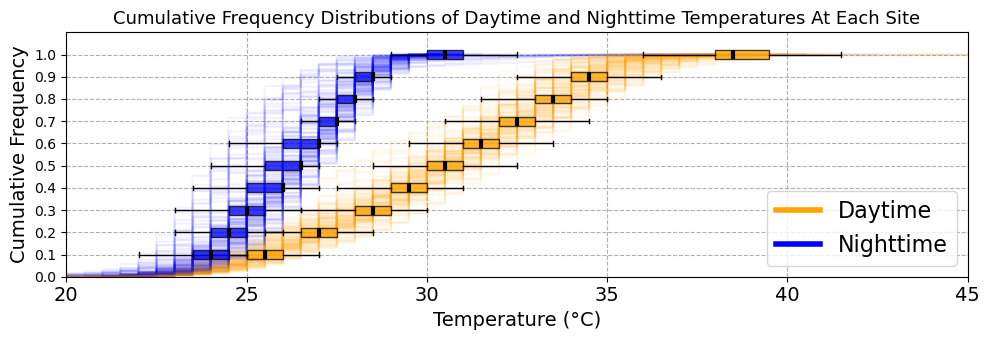

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate a normalized cumulative sum
def compute_cdf(data):
    sorted_data = np.sort(data)
    cumdist = np.linspace(0., 1., len(sorted_data))
    return sorted_data, cumdist

# Function to retrieve temperature at a given percentile
def get_temperature_at_percentile(sorted_data, cumdist, percentile):
    return np.interp(percentile, cumdist, sorted_data)

# # Define the heat index categories
# heat_ranges =  [27, 33, 39, 46]
# heat_categories = ['Minimal', 'Low', 'Moderate', 'High', 'Extreme']

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 3.5))

daytime_percentile_data = {perc: [] for perc in np.arange(0.1, 1.1, 0.1)}
nighttime_percentile_data = {perc: [] for perc in np.arange(0.1, 1.1, 0.1)}

# Dummy lines for legend
line1, = ax.plot([], [], color='orange', linewidth=4)
line2, = ax.plot([], [], color='blue', linewidth=4)

# Iterate over sites and plot the CDFs
for site in tqdm(sorted_heat_sites.index):
    daytime_values = outdoor_temp[(outdoor_temp['site_id'] == site) & (outdoor_temp['Hour'].isin(daytime_hours))]['Value'].values
    nighttime_values = outdoor_temp[(outdoor_temp['site_id'] == site) & (outdoor_temp['Hour'].isin(nighttime_hours))]['Value'].values

    # Filter out nan values
    daytime_values = daytime_values[~np.isnan(daytime_values)]
    nighttime_values = nighttime_values[~np.isnan(nighttime_values)]

    # If there's no data left after filtering, continue to the next site
    if len(daytime_values) == 0 or len(nighttime_values) == 0:
        continue

# Compute CDF for daytime temperatures of this site
    sorted_daytime, cumdist_daytime = compute_cdf(daytime_values)
    ax.plot(sorted_daytime, cumdist_daytime, color='orange', alpha=0.05)
    
    # Compute CDF for nighttime temperatures of this site
    sorted_nighttime, cumdist_nighttime = compute_cdf(nighttime_values)
    ax.plot(sorted_nighttime, cumdist_nighttime, color='blue', alpha=0.05)

    # Retrieve temperature values at each 10th percentile
    for perc in np.arange(0.1, 1.1, 0.1):
        daytime_temp = get_temperature_at_percentile(sorted_daytime, cumdist_daytime, perc)
        nighttime_temp = get_temperature_at_percentile(sorted_nighttime, cumdist_nighttime, perc)
        daytime_percentile_data[perc].append(daytime_temp)
        nighttime_percentile_data[perc].append(nighttime_temp)

# Boxplot properties
medianprops = dict(linestyle='-', linewidth=3, color='black')

# Plot boxplots for daytime and nighttime data at each 10th percentile
for perc, daytime_values in daytime_percentile_data.items():
    ax.boxplot(daytime_values, positions=[perc], widths=0.04, vert=False, patch_artist=True, boxprops=dict(facecolor="orange", alpha=0.75), medianprops=medianprops, showfliers=False)

for perc, nighttime_values in nighttime_percentile_data.items():
    ax.boxplot(nighttime_values, positions=[perc], widths=0.04, vert=False, patch_artist=True, boxprops=dict(facecolor="blue", alpha=0.75), medianprops=medianprops, showfliers=False)

# Add the vertical lines and labels
# for index, heat_range in enumerate(heat_ranges):
#     ax.axvline(heat_range, color='red', linestyle='--', linewidth=1.2)
#     prev_range = heat_ranges[index-1] if index > 0 else 0
#     midpoint = (prev_range + heat_range) / 2
#     y_position = 1.025
#     if index == 0:
#         ax.text(22, y_position, heat_categories[index], horizontalalignment='left', fontsize=12, color='red')
#     else:
#         ax.text(midpoint, y_position, heat_categories[index], horizontalalignment='center', fontsize=12, color='red')

# last_range = heat_ranges[-1]
# # max_x = ax.get_xlim()[1]
# # midpoint = (last_range + max_x) / 2
# ax.text(55, 1.025, heat_categories[-1], horizontalalignment='center', fontsize=12, color='red')

# Add labels, title, legend, etc.
ax.set_xlabel('Temperature (°C)', fontsize = 14)
ax.set_ylabel('Cumulative Frequency', fontsize = 14)
ax.set_title('Cumulative Frequency Distributions of Daytime and Nighttime Temperatures At Each Site', fontsize = 13)
ax.legend([line1, line2], ['Daytime', 'Nighttime'], loc='lower right', fontsize=16)

# Adjust y-axis settings
ax.set_ylim([0, 1.1])  # Update the y-axis limit
ax.set_xlim([20, 45])  # Update the x-axis limit
ax.set_yticks(np.arange(0, 1.1, 0.1))  
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())  # Fix y-axis tick formatting

# Grid and show
plt.grid(True, which="both", ls="--")
plt.xticks(fontsize = 14)
# plt.ticks(fontsize = 14)
plt.tight_layout()
plt.savefig(figure_directory+'/CMF_outdoor_temperatures.png', bbox_inches='tight')


In [45]:
# dwelling_variables = ['dwelling_type', 'roof_material', 'roof_shape', 'wall_material', 'floor_material', 'ceiling_material', 'roof_wall_gap', 'roof_colour', 'window_type', 'window_type_other', 'window_orientiation_1', 'window_orientation_2', 'number_rooms', 'dwelling_floors', 'shade_trees_yesno', 'shade_buildings_yesno', 'aircon_yesno', 'windows_yesno']
dwelling_variables = ['dwelling_type', 'roof_material', 'roof_shape', 'wall_material', 'floor_material', 'ceiling_material', 'roof_wall_gap', 'roof_colour', 'window_type', 'window_type_other', 'dwelling_floors', 'shade_trees_yesno', 'shade_buildings_yesno', 'aircon_yesno', 'windows_yesno']
for variable in dwelling_variables:
    print(merged_df[variable].value_counts())
    print("\n")

dwelling_type
1    413640
4    191964
2    141010
3     98322
5      7480
Name: count, dtype: int64


roof_material
4    374984
3    332221
1     87428
6     30653
8     14114
7      7503
2      5513
Name: count, dtype: int64


roof_shape
3.0    436390
1.0    397447
Name: count, dtype: int64


wall_material
2.0     747406
7.0      29965
9.0      29570
11.0     22256
10.0      8182
1.0       7850
6.0       1549
Name: count, dtype: int64


floor_material
3.0    455462
2.0    293673
5.0     62612
6.0     32537
Name: count, dtype: int64


ceiling_material
3.0    508942
1.0    144968
4.0     81421
2.0     76764
Name: count, dtype: int64


roof_wall_gap
0.0    725996
1.0     77570
Name: count, dtype: int64


roof_colour
Ash          281171
Silver       110192
Blue          53648
Grey          50122
White         35811
Silver        33019
Red           32440
Brown         22525
Green         21248
Brown         20821
Grey          12220
Sea blue      10128
Black          9817
Ash            8

In [47]:
dwelling_dict = {1: 'Separate house (detached)',
2: 'Semi-detached house',
3: 'Flat/Apartment',
4: 'Compound house (rooms)',
5: 'Huts/buildings (same compound)',
6: 'Wooden structure',
7: 'Metal container',
8: 'Living quarter attached to office/shop',
9: 'Other'}

roof_mat_dict = {
1: 'Cement/Concrete',
2: 'Roofing tiles',
3: 'Metal sheet',
4: 'Slate/Asbestos',
5: 'Bamboo',
6: 'Mud/Mud bricks/Earth',
7: 'Thatch/Palm leaves/Raffia',
8: 'Wood',
9: 'Clay',
10: 'Other'
}

roof_shape_dict = {
1: 'Flat',
2: 'Shallow',
3: 'Pitched',
4: 'Cannot be determined'
}

wall_dict = {
1: 'Burnt bricks',
2: 'Cement blocks/Concrete',
3: 'Landcrete',
4: 'Metal sheet/slate/asbestos',
5: 'Stone',
6: 'Bamboo',
7: 'Mud bricks/earth',
8: 'Palm leaves/thatch/raffia',
9: 'Wood',
10: 'Tile',
11: 'Terrazzo tile',
12: 'Other'
}

floor_dict = {
1: 'Burnt bricks',
2: 'Cement/concrete',
3: 'Ceramic/porcelain/granite/marble tiles',
4: 'Stone',
5: 'Terazzo/terazzo tiles',
6: 'Vinyl tiles',
7: 'Earth/mud',
8: 'Wood',
9: 'Other'
}

ceiling_dict = {
1: 'No ceiling',
2: 'Plaster of Paris',
3: 'Wood',
4: 'TMG',
5: 'Other'
}

window_dict = {
1: 'Plain opening/screen only',
2: 'Shutters',
3: 'Sliding glass',
4: 'Other'}

shade_trees_dict = {1: 'Yes', 0: 'No'}
shade_buildings_dict = {1: 'Yes', 0: 'No'}
roof_gap_dict = {1: 'Yes', 0: 'No'}
aircon_dict = {1: 'Yes', 0: 'No'}
window_yesno = {1: 'Yes', 0: 'No'}

merged_df['dwelling_type'].replace(dwelling_dict, inplace=True)
merged_df['roof_material'].replace(roof_mat_dict, inplace=True)
merged_df['roof_shape'].replace(roof_shape_dict, inplace=True)
merged_df['wall_material'].replace(wall_dict, inplace=True)
merged_df['floor_material'].replace(floor_dict, inplace=True)
merged_df['ceiling_material'].replace(ceiling_dict, inplace=True)
merged_df['roof_wall_gap'].replace(roof_gap_dict, inplace=True)
merged_df['window_type'].replace(window_dict, inplace=True)
merged_df['shade_trees_yesno'].replace(shade_trees_dict, inplace=True)
merged_df['shade_buildings_yesno'].replace(shade_buildings_dict, inplace=True)
merged_df['aircon_yesno'].replace(aircon_dict, inplace=True)
merged_df['windows_yesno'].replace(window_yesno, inplace=True)

# Assuming your dataframe has a datetime column named "timestamp"
merged_df['Date'] = merged_df['Date/Time'].dt.date

# Step 1: Day-Level Aggregation with 'site_type_outdoor'
day_level = merged_df.groupby(['sensor_id_indoor_temp', 'Date', 'Day/night']).agg(
    daily_mean_indoor=('Indoor_Value', 'mean'),
    daily_mean_outdoor=('Value', 'mean'),
    daily_max_indoor=('Indoor_Value', 'max'),
    daily_max_outdoor=('Value', 'max'),
    dwelling_type=('dwelling_type', 'first'),  # assuming consistent for a given sensor and day
    roof_material=('roof_material', 'first'),
    roof_shape=('roof_shape', 'first'),
    roof_colour=('roof_colour', 'first'),
    wall_material=('wall_material', 'first'),
    floor_material=('floor_material', 'first'),
    ceiling_material=('ceiling_material', 'first'),
    roof_wall_gap=('roof_wall_gap', 'first'),
    window_type=('window_type', 'first'),
    dwelling_floors=('dwelling_floors','first'),
    shade_trees_yesno=('shade_trees_yesno', 'first'),
    windows_yesno=('windows_yesno', 'first'),
    aircon_yesno=('aircon_yesno', 'first'),
    site_type_outdoor=('site_type_outdoor', 'first')
).reset_index()

# Calculate temperature difference for each day and night period for each sensor
day_level['Temp_diff'] = day_level['daily_mean_indoor'] - day_level['daily_mean_outdoor']


In [48]:
# Filter data for only daytime
daytime_data = day_level[day_level['Day/night'] == 'Day']

# Compute difference between mean indoor and outdoor temperature for each sensor in daytime
daytime_data['mean_temp_diff'] = daytime_data['daily_mean_indoor'] - daytime_data['daily_mean_outdoor']

# Average this difference for each sensor
avg_diff_data = daytime_data.groupby('sensor_id_indoor_temp')['mean_temp_diff'].mean().reset_index()

dwelling_characteristics = merged_df.drop_duplicates('sensor_id_indoor_temp')[['sensor_id_indoor_temp']+dwelling_variables]

analysis_data = avg_diff_data.merge(dwelling_characteristics, on='sensor_id_indoor_temp', how='left')


/tmp/ipykernel_1049/3819810978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daytime_data['mean_temp_diff'] = daytime_data['daily_mean_indoor'] - daytime_data['daily_mean_outdoor']


In [49]:
import statsmodels.formula.api as smf

# model = smf.ols(formula='mean_temp_diff ~ '+''.join([' + C('+variable+')' for variable in dwelling_variables]), data=analysis_data)

# reg_variables = ['dwelling_type', 'roof_material', 'roof_shape', 'wall_material', 'floor_material', 'ceiling_material', 'roof_wall_gap', 'roof_colour', 'window_type', 'window_type_other', 'dwelling_floors', 'shade_trees_yesno', 'shade_buildings_yesno', 'aircon_yesno', 'windows_yesno']
reg_variables = ['dwelling_type', 'roof_material', 'roof_shape', 'wall_material', 'floor_material', 'ceiling_material', 'roof_wall_gap', 'window_type', 'dwelling_floors', 'shade_trees_yesno', 'shade_buildings_yesno', 'aircon_yesno', 'windows_yesno']
model = smf.ols(formula='mean_temp_diff ~ '+''.join([' + C('+variable+')' for variable in reg_variables]), data=analysis_data)

# model = smf.ols(formula='mean_temp_diff ~ C(wall_material) + C(roof_material) + C(dwelling_type) + C(ceiling_material) + C(roof_wall_gap) + C(dwelling_floors) + C(window_type) + C(windows_yesno) + C(dwelling_floors) + C(shade_trees_yesno) + C(shade_buildings_yesno)', data=analysis_data)

results = model.fit()

# variables = ['wall_material', 'roof_material', 'dwelling_type', 'ceiling_material', 'roof_shape', 'roof_wall_gap']

for variable in reg_variables:
    print("Reference for "+variable+":", merged_df[variable].dropna().sort_values().unique()[0])

print(results.summary())

Reference for dwelling_type: Compound house (rooms)
Reference for roof_material: Cement/Concrete
Reference for roof_shape: Flat
Reference for wall_material: Bamboo
Reference for floor_material: Cement/concrete
Reference for ceiling_material: No ceiling
Reference for roof_wall_gap: No
Reference for window_type: Other
Reference for dwelling_floors: 0.0
Reference for shade_trees_yesno: No
Reference for shade_buildings_yesno: No
Reference for aircon_yesno: No
Reference for windows_yesno: No
                            OLS Regression Results                            
Dep. Variable:         mean_temp_diff   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     2.568
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           0.000831
Time:                        09:40:33   Log-Likelihood:                -100.31
No. Observations:                 

In [50]:
def format_variable_name(name):
    # Removing the prefix 'C(...)[T.' and the closing ']'
    formatted_name = name.replace('C(', '').replace('[T.', ': ').replace(']', '')

    # Splitting into main variable and category, if applicable
    parts = formatted_name.split(': ')
    main_var = parts[0].replace('_', ' ').capitalize()

    # Formatting the category, if it exists
    if len(parts) > 1:
        category = parts[1].replace('_', ' ').capitalize()
        return f"({main_var} {category}"
    else:
        return main_var

# # Applying the function to each variable name
# formatted_variables = [format_variable_name(var) for var in variables]

# print(formatted_variables)


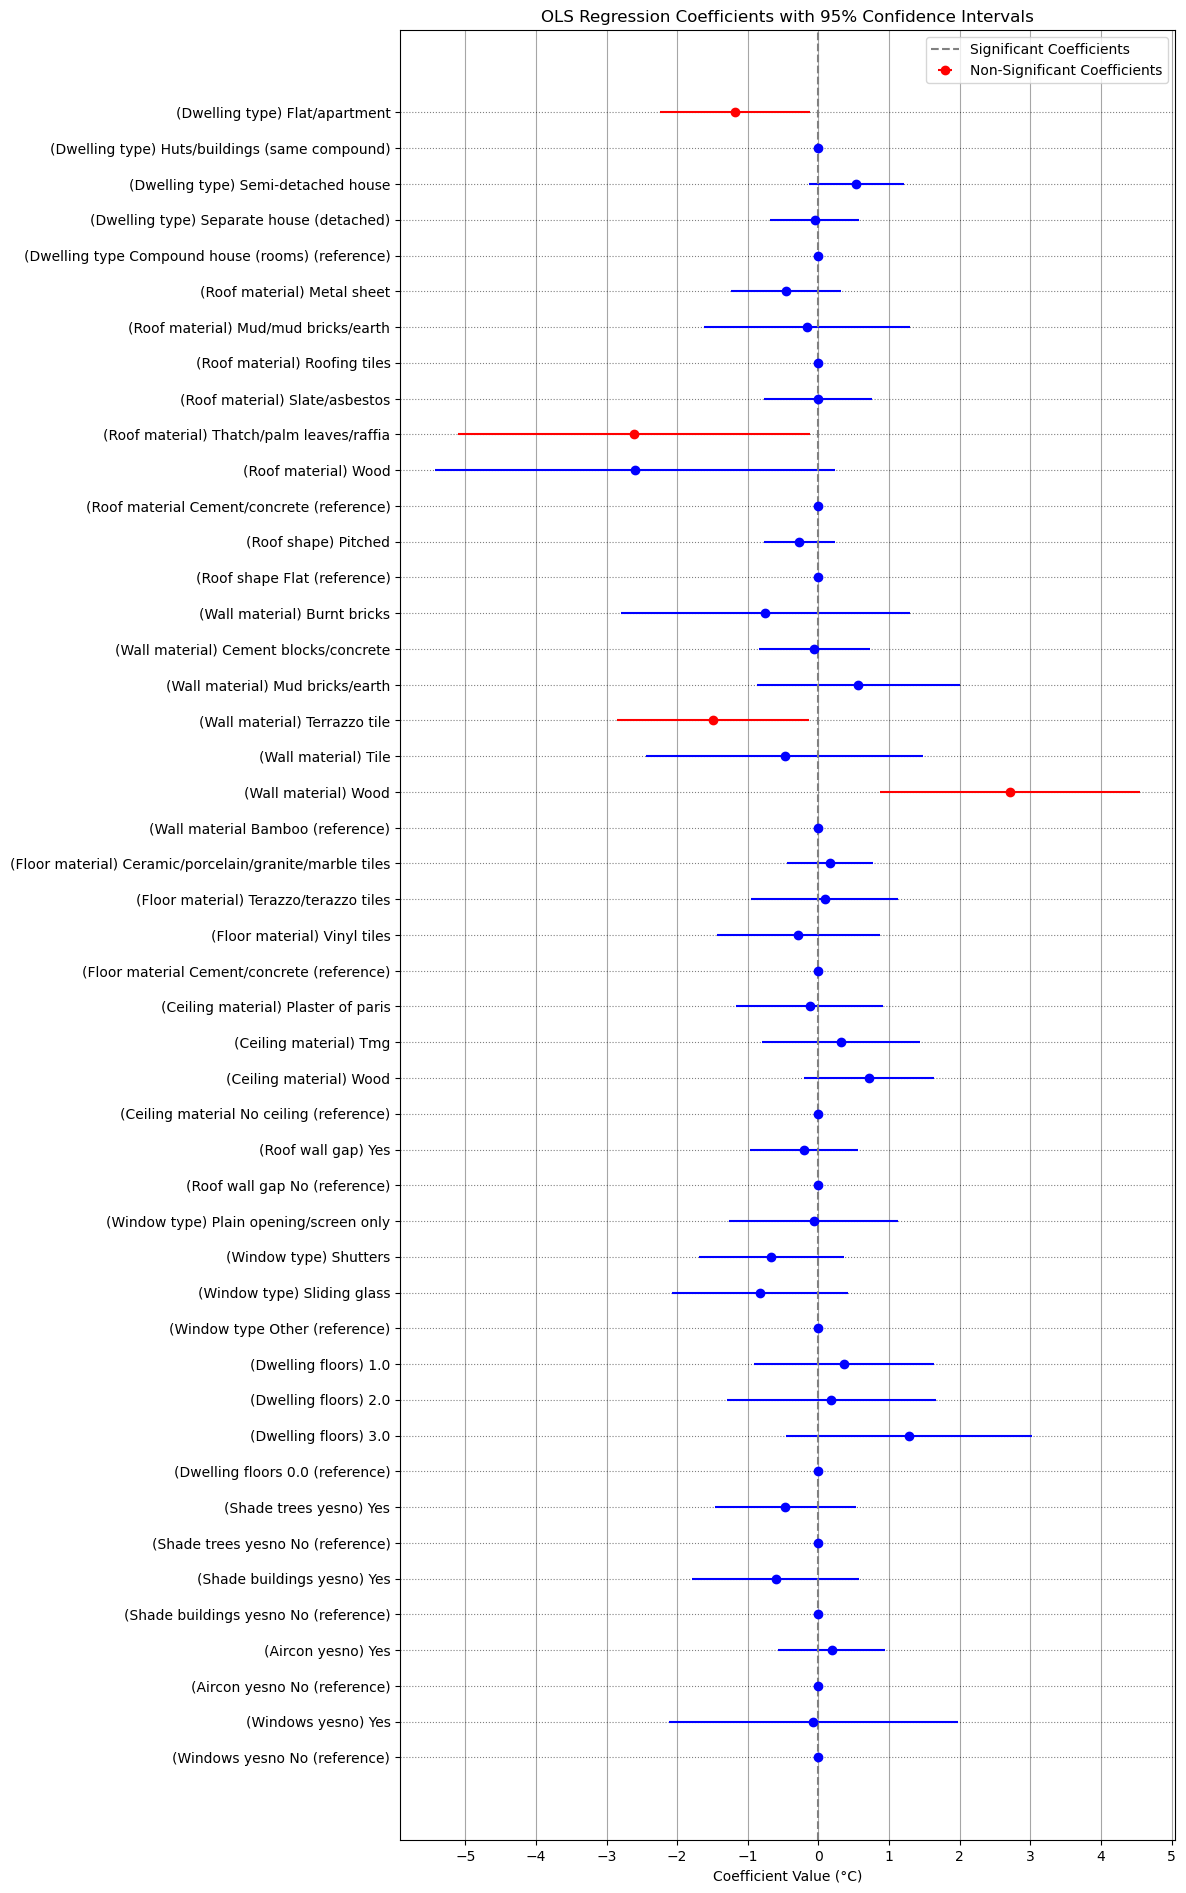

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting coefficients, standard errors, and confidence intervals
coefficients = results.params
standard_errors = results.bse
confidence_intervals = results.conf_int()

# Preparing data for plotting
variables = coefficients.index
y_pos = np.arange(len(variables))
lower_errors = coefficients - confidence_intervals.iloc[:, 0]
upper_errors = confidence_intervals.iloc[:, 1] - coefficients
errors = np.array([lower_errors, upper_errors])  # upper and lower errors

# Formatting variable names
formatted_variables = [format_variable_name(var) for var in variables]

# Initializing arrays to hold new ordering and data
new_coefficients = []
new_errors = []
new_significant = []
new_formatted_variables = []

# Insert reference categories directly into data arrays
for variable in reg_variables:
    # Identifying indices for the current variable
    var_indices = [i for i, var in enumerate(variables) if variable in var]
    
    # Appending variable data to new lists
    for idx in var_indices:
        new_coefficients.append(coefficients.iloc[idx])
        # Directly indexing the NumPy array
        new_errors.append([errors[0][idx], errors[1][idx]])
        new_significant.append(significant.iloc[idx])
        new_formatted_variables.append(formatted_variables[idx])
    
    # Adding reference category for the variable
    ref_category_name = format_variable_name(f"{variable.capitalize()}: {merged_df[variable].dropna().sort_values().unique()[0]} (Reference)")
    new_formatted_variables.append(ref_category_name)
    new_coefficients.append(0)  # Reference category coefficient is 0
    new_errors.append([0, 0])  # No error for reference categories
    new_significant.append(False)  # Reference categories are not tested for significance

# Updating y_pos for new order
new_y_pos = np.arange(len(new_formatted_variables))

# Creating the plot
plt.figure(figsize=(10, len(new_formatted_variables)/2))

# Plotting coefficients and error bars
for i, coef in enumerate(new_coefficients):
    color = 'r' if new_significant[i] else 'b'
    err = np.array(new_errors[i]).reshape(2, -1)
    plt.errorbar(coef, new_y_pos[i], xerr=err, fmt='o', color=color)

plt.axvline(x=0, color='grey', linestyle='--')

# Adding labels and title
plt.yticks(new_y_pos, new_formatted_variables)
plt.xlabel('Coefficient Value (°C)')
plt.title('OLS Regression Coefficients with 95% Confidence Intervals')

# Adding grid lines for better readability
plt.grid(axis='x', linestyle='-', alpha=0.7, which='major', color='grey')
plt.grid(axis='y', linestyle=':', alpha=0.5, which='major', color='black')

# Set x-axis ticks at 1°C increments
plt.xticks(np.arange(np.floor(min(new_coefficients)) - 2, np.ceil(max(new_coefficients)) + 3, 1.0))

# Adding a legend
plt.legend(['Significant Coefficients', 'Non-Significant Coefficients'], loc='best')

plt.gca().invert_yaxis()  # Optional: Invert y-axis so top is first variable
plt.savefig('coefficients_with_refs_reordered_correctly.png', bbox_inches='tight')


In [53]:
indoor_hum = pd.read_csv('./campaign_data/indoor_hum.csv')

/tmp/ipykernel_1049/645579396.py:1: DtypeWarning: Columns (8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  indoor_hum = pd.read_csv('./campaign_data/indoor_hum.csv')


In [54]:
indoor_hum['Date/Time'] = pd.to_datetime(indoor_hum['Date/Time'])
indoor_hum.set_index('Date/Time', inplace=True)
common_sites = set(indoor_hum['site_id']).intersection(set(outdoor_hum['site_id']))

In [55]:
indoor_hum.columns

Index(['point_id_indoor_hum', 'Unit', 'Value', 'sensor_id_indoor_hum',
       'site_id', 'filename', 'hh_id', 'hh_notes', 'gps_lat', 'gps_long',
       'gps_ghanapost', 'photo_ext', 'photo_int',
       'indoor_sensor_deployment_complete', 'site_type', 'Road_surface',
       'pop_dens', 'WB_cat', 'ndvi', 'pop_dens_cat', 'ndvi_cat'],
      dtype='object')

In [56]:
# Sort both dataframes by 'Date/Time'
outdoor_hum.sort_values('Date/Time', inplace=True)
indoor_hum.sort_values('Date/Time', inplace=True)

# Rename 'Value' column in indoor dataframe to avoid confusion after merge
indoor_hum.rename(columns={'Value': 'Indoor_Value'}, inplace=True)

# Merge the dataframes
hum_merged_df = pd.merge_asof(outdoor_hum, indoor_hum, 
                          on='Date/Time', by='site_id', 
                          tolerance=pd.Timedelta('1 hour'), direction='nearest', suffixes=('_outdoor', '_indoor'))

# Set 'Date/Time' back as index
hum_merged_df.set_index('Date/Time', inplace=True)

Processing site AD, sensor AD_9469, 14771 data points available
Processing site AD, sensor AD_9AAA, 4552 data points available
Processing site ASH, sensor ASH_9866, 11101 data points available
Processing site LA, sensor LA_929F, 9140 data points available
Processing site LA, sensor LA_A27F, 11111 data points available
Processing site UGH, sensor UGH_9BA3, 5514 data points available
Processing site UGH, sensor UGH_A113, 506 data points available
Processing site UGH, sensor UGH_98B4, 6010 data points available
Processing site EL, sensor EL_9AA4, 6228 data points available
Processing site EL, sensor EL_9E05, 5548 data points available
Processing site EL, sensor EL_55A5, 1345 data points available
Processing site JT, sensor JT_9351, 30180 data points available
Processing site JT, sensor JT_A268, 2215 data points available
Processing site JT, sensor JT_A094, 2011 data points available
Processing site NM, sensor NM_9918, 4959 data points available
Processing site NM, sensor NM_A26C, 2719 dat